In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import pickle
import numpy as np
import random
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
import os
import copy
import math

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [7]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

In [3]:
DATA_MODES = ['train', 'val', 'test']

RESCALE_SIZE = 224

DEVICE = torch.device("cuda")

In [69]:
class RealEstateDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):       
        transform = {
            'train': transforms.Compose(
                [
                    transforms.Resize(RESCALE_SIZE),
                    transforms.CenterCrop(RESCALE_SIZE),
                    transforms.RandomChoice(
                        [
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ColorJitter(contrast=0.1),
                            transforms.ColorJitter(brightness=0.1),
                            transforms.RandomApply(
                                [
                                    transforms.RandomHorizontalFlip(p=1), 
                                    transforms.ColorJitter(contrast=0.1)
                                ], 
                                p=0.5
                            ),
                            transforms.RandomApply(
                                [
                                    transforms.RandomHorizontalFlip(p=1), 
                                    transforms.ColorJitter(brightness=0.1)
                                ], 
                                p=0.5),
                        ]
                    ),
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]
            ),
            'val': transforms.Compose(
                [
                    transforms.Resize(RESCALE_SIZE),
                    transforms.CenterCrop(RESCALE_SIZE),
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]
            ),
            'test': transforms.Compose(
                [
                    transforms.Resize(RESCALE_SIZE),
                    transforms.CenterCrop(RESCALE_SIZE),
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]
            )
        }

        x = self.load_sample(self.files[index])

        x = transform[self.mode](x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [70]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [78]:
TRAIN_DIR = Path('../data/train')

TEST_DIR = Path('../data/val')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [79]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.3, \
                                          stratify=train_val_labels, random_state=42)

train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]    

In [80]:
val_dataset = RealEstateDataset(val_files, mode='val')
train_dataset = RealEstateDataset(train_files, mode='train')

In [81]:
dataloaders_dict = {
    'train': DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
}

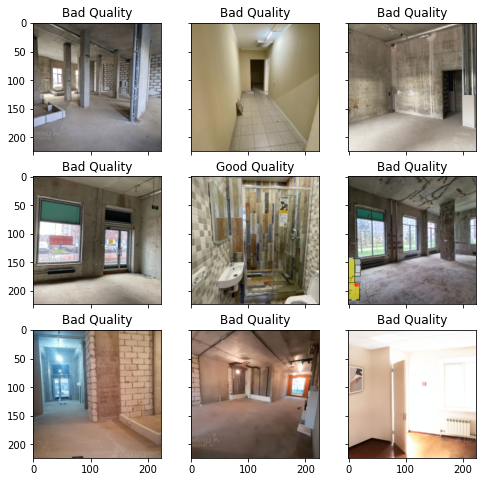

In [82]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

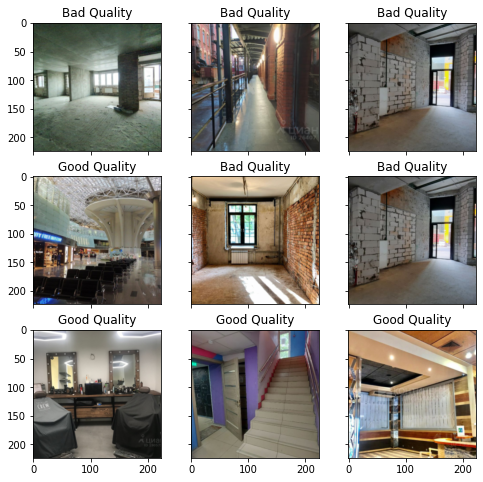

In [83]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,700))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [88]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [89]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [90]:
def train(train_dataset, val_dataset, model, epochs, batch_size, learning_rate):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=learning_rate, amsgrad=True)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step(val_loss)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [91]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [92]:
n_classes = len(np.unique(train_val_labels))

In [93]:
from torchvision import models

In [100]:
model_resnet50 = models.resnet50(pretrained=True).to(DEVICE)

# sd = model_resnet50.state_dict()
# sd.update(torch.load('../models/resnet50_pretrained.pth'))
# model_resnet50.load_state_dict(sd)

for param in model_resnet50.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default

num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, n_classes)
)

In [101]:
params_to_update = model_resnet50.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model_resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.0.weight
	 fc.0.bias
	 fc.2.weight
	 fc.2.bias
	 fc.4.weight
	 fc.4.bias


In [102]:
model_resnet50 = model_resnet50.to(DEVICE)

In [103]:
history = train(train_dataset, val_dataset, model=model_resnet50,
                epochs=6, batch_size=64, learning_rate=1e-3)

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 0.48503162894624147


epoch:  17%|█▋        | 1/6 [00:33<02:46, 33.39s/it]


Epoch 001 train_loss: 0.4850     val_loss 0.2713 train_acc 0.8078 val_acc 0.9035
loss 0.22313332241439313


epoch:  33%|███▎      | 2/6 [01:05<02:10, 32.64s/it]


Epoch 002 train_loss: 0.2231     val_loss 0.2863 train_acc 0.9249 val_acc 0.8952
loss 0.21003261377708873


epoch:  50%|█████     | 3/6 [01:38<01:38, 33.00s/it]


Epoch 003 train_loss: 0.2100     val_loss 0.2215 train_acc 0.9257 val_acc 0.9232
loss 0.18780397916891708


epoch:  67%|██████▋   | 4/6 [02:11<01:05, 32.96s/it]


Epoch 004 train_loss: 0.1878     val_loss 0.2310 train_acc 0.9368 val_acc 0.9175
loss 0.1964109149464073


epoch:  83%|████████▎ | 5/6 [02:43<00:32, 32.56s/it]


Epoch 005 train_loss: 0.1964     val_loss 0.2287 train_acc 0.9303 val_acc 0.9213
loss 0.18106735834236726


epoch: 100%|██████████| 6/6 [03:15<00:00, 32.66s/it]


Epoch 006 train_loss: 0.1811     val_loss 0.2402 train_acc 0.9333 val_acc 0.9149


In [106]:
loss, acc, val_loss, val_acc = zip(*history)

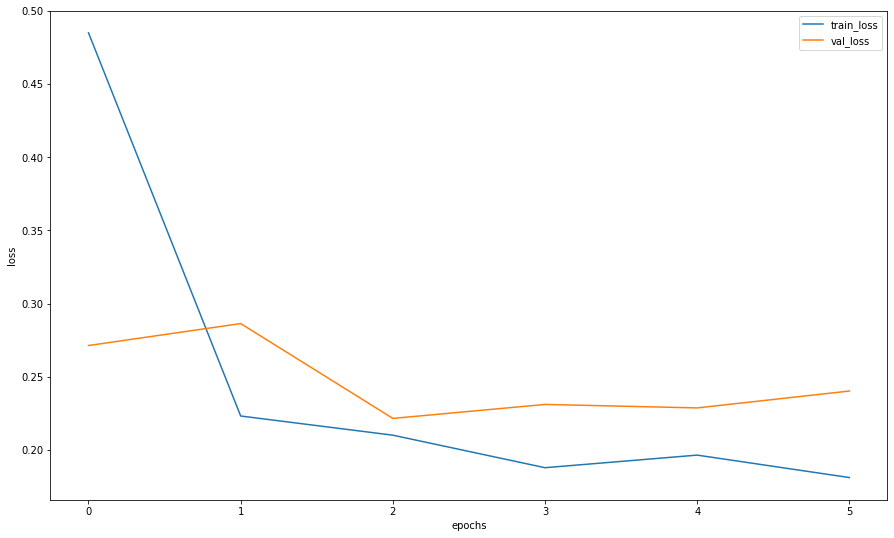

In [107]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Сохраним нашу модель на текущем этапе.

In [108]:
import copy

model_only_fc_layer = copy.deepcopy(model_resnet50.state_dict())
torch.save(model_only_fc_layer, "model_only_fc_layer.pth")

In [109]:
for param in model_resnet50.parameters():
    param.requires_grad = True

In [64]:
# params_to_update = model_resnet50.parameters()
# print("Params to learn:")

# params_to_update = []
# for name,param in model_resnet50.named_parameters():
#     if param.requires_grad == True:
#         params_to_update.append(param)
#         print("\t",name)

In [110]:
history = train(train_dataset, val_dataset, model=model_resnet50, epochs=12, batch_size=64,
               learning_rate=1e-4)

epoch:   0%|          | 0/12 [00:00<?, ?it/s]

loss 0.3870926141219603


epoch:   8%|▊         | 1/12 [00:32<05:55, 32.31s/it]


Epoch 001 train_loss: 0.3871     val_loss 0.2139 train_acc 0.8652 val_acc 0.9175
loss 0.19467401186452066


epoch:  17%|█▋        | 2/12 [01:04<05:21, 32.12s/it]


Epoch 002 train_loss: 0.1947     val_loss 0.2097 train_acc 0.9281 val_acc 0.9200
loss 0.15783485944674186


epoch:  25%|██▌       | 3/12 [01:37<04:53, 32.58s/it]


Epoch 003 train_loss: 0.1578     val_loss 0.2325 train_acc 0.9431 val_acc 0.9124
loss 0.1428785055364603


epoch:  33%|███▎      | 4/12 [02:08<04:17, 32.13s/it]


Epoch 004 train_loss: 0.1429     val_loss 0.2109 train_acc 0.9464 val_acc 0.9232
loss 0.12733461826901782


epoch:  42%|████▏     | 5/12 [02:40<03:43, 31.95s/it]


Epoch 005 train_loss: 0.1273     val_loss 0.4638 train_acc 0.9537 val_acc 0.8622
loss 0.12960029430580933


epoch:  50%|█████     | 6/12 [03:13<03:14, 32.34s/it]


Epoch 006 train_loss: 0.1296     val_loss 0.2068 train_acc 0.9553 val_acc 0.9333
loss 0.10719107342551783


epoch:  58%|█████▊    | 7/12 [03:45<02:40, 32.16s/it]


Epoch 007 train_loss: 0.1072     val_loss 0.2395 train_acc 0.9564 val_acc 0.9302
loss 0.06943646946903181


epoch:  67%|██████▋   | 8/12 [04:17<02:08, 32.22s/it]


Epoch 008 train_loss: 0.0694     val_loss 0.2430 train_acc 0.9755 val_acc 0.9162
loss 0.06392286316659773


epoch:  75%|███████▌  | 9/12 [04:49<01:36, 32.22s/it]


Epoch 009 train_loss: 0.0639     val_loss 0.2443 train_acc 0.9790 val_acc 0.9219
loss 0.0816305996198486


epoch:  83%|████████▎ | 10/12 [05:22<01:04, 32.27s/it]


Epoch 010 train_loss: 0.0816     val_loss 0.3229 train_acc 0.9720 val_acc 0.9029
loss 0.049189026450006536


epoch:  92%|█████████▏| 11/12 [05:54<00:32, 32.31s/it]


Epoch 011 train_loss: 0.0492     val_loss 0.3673 train_acc 0.9834 val_acc 0.9137
loss 0.033555414483471976


epoch: 100%|██████████| 12/12 [06:27<00:00, 32.28s/it]


Epoch 012 train_loss: 0.0336     val_loss 0.2709 train_acc 0.9875 val_acc 0.9352


In [114]:
model_resnet50_25epoch_weights = copy.deepcopy(model_resnet50.state_dict())
torch.save(model_resnet50_25epoch_weights, "../models/resnet50_weights_trained.pth")

In [115]:
# model_resnet50.load_state_dict(torch.load("model_pre_weights.pth"))

In [116]:
loss, acc, val_loss, val_acc = zip(*history)

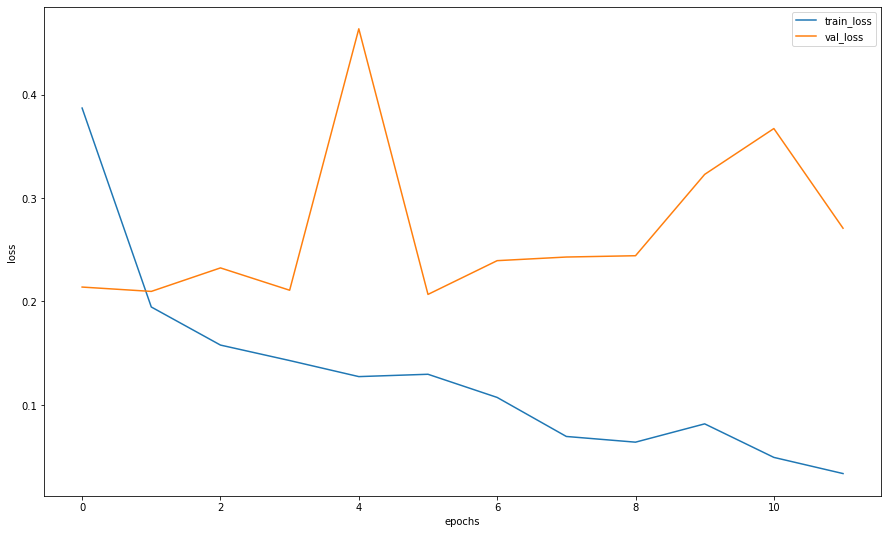

In [117]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [118]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [119]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_resnet50, ex_img.unsqueeze(0))

In [120]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_resnet50, imgs)

In [121]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [122]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [123]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.9

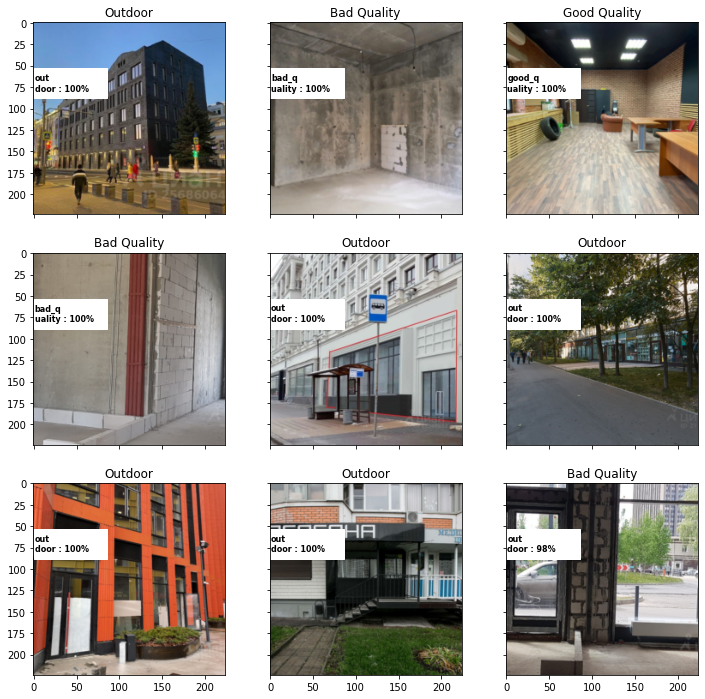

In [125]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_resnet50, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')